## Estimate $\tau_{KCC2}$ that compensates for a change in $E_{Cl}$ (via $I_{Cl}$)

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from __future__ import absolute_import, division, print_function

import time

from matplotlib import pyplot as plt

from settings import COLOR, text, logging, time_unit

# start from defaults before loading stylesheet
plt.style.use("default")
plt.style.use("style/article.mplstyle")

logger = logging.getLogger("tau")

In [5]:
import brian2.numpy_ as np
from brian2 import *
from brian2.units.constants import faraday_constant as F
from brian2.units.constants import gas_constant as R
from brian2.units.constants import zero_celsius
from brian2tools import brian_plot, plot_state

################################################################################
# Settings
################################################################################

celsius_temp = 37  # Temperature
T = celsius_temp * kelvin + zero_celsius
rt_f = R * T / F

start_time = time.time()
sum_time = 0
# seed(11999)  # to get identical figures for repeated runs
start_scope()

################################################################################
# Model parameters
################################################################################
# Network
N = 1  # Number of total neurons

# Neuron
V_thr = -50.0 * mV  # Firing threshold
V_reset = -70.0 * mV  # Reset potential
C_m = 0.550 * nF  # Membrane capacitance (excitatory population)
tau_r = 2.0 * ms  # Refractory period (excitatory population)

# Size
L = 7.5 * um  # Length
a = L / 2
volume = 4.0 / 3.0 * pi * (L / 2) * (a**2)  # volume oblate spheroid

# Leak
E_leak = -70.0 * mV  # Leak reversal potential
g_l = 20.0 * nS  # Leak conductance (excitatory population)

# GABAergic (inhibitory)
g_GABA_max = 5 * nS
tau_GABA = 10.0 * ms
E_Cl_0 = -88.0 * mV  # Reversal potential for Chloride
E_HCO3 = -10 * mV  # Reversal potential for Bicarbonate
pcl = 0.8  # Permeability proportion of Chloride through GABAA
phco3 = 1 - pcl  # Permeability proportion of Bicarbonate through GABAA
C_Cl_in = 5 * mM  # Internal chloride concentration (indirectly varied through d_ECl/dt)
C_Cl_out = C_Cl_in / exp(
    E_Cl_0 * (1 / rt_f)
)  # External chloride concentration (constant)
ecl_alpha = rt_f / (F * volume * C_Cl_out)
ecl_beta = 1 / rt_f
E_GABA_0 = (
    pcl * E_Cl_0 + phco3 * E_HCO3
)  # Reversal potential for GABAA (Ohmic formulation using Cl and HCO3
#  permeabilities)
logger.debug("EGABA = {:.2f}".format(E_GABA_0 / mV))

tau_KCC2_0 = 40 * second

################################################################################
# Model definition
################################################################################
dE_Cl_influx = "ecl_alpha * exp( -(ecl_beta * E_Cl)) * I_Cl"
dE_Cl_efflux = "(E_Cl - E_Cl_0)/tau_KCC2"
neuron_eqs = f"""
    in_eff: 1
    out_eff: 1
    tau_KCC2: second

    E_GABA = pcl * E_Cl + phco3 * E_HCO3 : volt       
    I_GABA = g_GABA * (v - E_GABA) : amp
    I_Cl = pcl*g_GABA * (v - E_Cl) : amp

    dv / dt = (- g_l * (v - E_leak) - I_GABA) / C_m : volt
    dE_Cl / dt = in_eff*{dE_Cl_influx} - out_eff*{dE_Cl_efflux} : volt
    dg_GABA / dt = - g_GABA / tau_GABA : siemens

"""
# noinspection PyTypeChecker
neurons = NeuronGroup(
    N,
    neuron_eqs,
    threshold="v > V_thr",
    reset="v = V_reset",
    refractory="tau_r",
    method="euler",
)

# ##############################################################################
# # Initialisation
# ##############################################################################
neurons.v = E_leak
neurons.in_eff = 1
neurons.out_eff = 0
neurons.tau_KCC2 = tau_KCC2_0
neurons.E_Cl = E_Cl_0
neurons.g_GABA = 0 * nS

# external
rate_ext = 5 * Hz
num_inputs = 1
P = PoissonInput(neurons, "g_GABA", num_inputs, rate_ext, "g_GABA_max")

# ##############################################################################
# # Monitors
# ##############################################################################
v_vars = ["E_GABA", "E_Cl", "v"]
i_vars = ["I_GABA", "I_Cl"]
g_state_mon = StateMonitor(neurons, ["g_GABA"], record=True)
v_state_mon = StateMonitor(neurons, v_vars, record=True)
i_state_mon = StateMonitor(neurons, i_vars, record=True)

setup_time = time.time()
setup_dt = setup_time - start_time
sum_time += setup_dt
logger.info("took {:.2f}s to setup".format(setup_dt))

INFO       took 0.01s to setup [brian2]


In [6]:
def calc_tau_kcc2_alt(icl, ecl, ecl_inf=E_Cl_0, vol=volume, clo=C_Cl_out):
    ecl_influx = icl / (ecl_beta * np.exp(ecl_beta*ecl) * F * vol * clo)
    return (ecl - ecl_inf) / ecl_influx

def calc_tau_kcc2(icl, ecl, ecl_inf=E_Cl_0):
    ecl_influx = ecl_alpha * exp(-(ecl_beta * ecl)) * icl
    return (ecl - ecl_inf) / ecl_influx

In [7]:
from tqdm import tqdm

logger.info("running")
single_run = 10 * second
prev_time_index = -int(single_run / defaultclock.dt)

pbar = tqdm(total=float("inf"), unit="s (simulated)")
logging.getLogger("root").setLevel(logging.WARNING)
total_duration = 0
taus = []
while True:
    run(single_run, report=None)
    total_duration += single_run

    pbar.set_description_str(f"E_Cl = {v_state_mon.E_Cl[0, -1]/mV:.3f} mV")
    pbar.update(single_run / second)

    delta_ecl = v_state_mon.E_Cl[0, -1] - v_state_mon.E_Cl[0, prev_time_index]

    sum_icl = np.sum(i_state_mon.I_Cl[0, prev_time_index:])

    tau = calc_tau_kcc2(sum_icl, v_state_mon.E_Cl[0, -1])
    tau_alt = calc_tau_kcc2_alt(sum_icl, v_state_mon.E_Cl[0, -1])
    assert np.round(tau, 3) == np.round(tau_alt, 3)

    taus.append(tau)

    if 0.01 * mV > delta_ecl:
        break


INFO       running [brian2]
E_Cl = -69.464 mV: 250.0s (simulated) [00:36,  6.82s (simulated)/s]

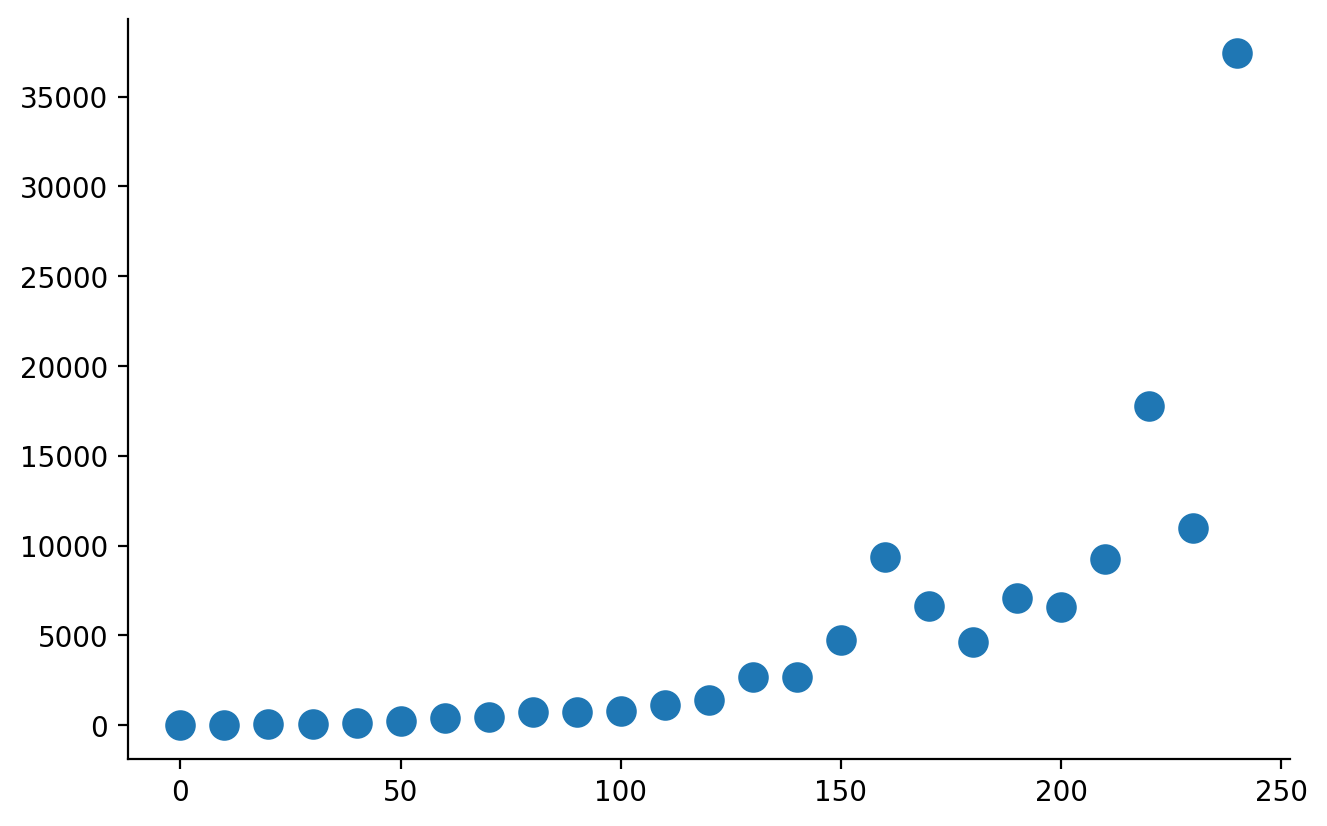

In [8]:
plt.scatter(np.arange(len(taus))*single_run, taus)

E_Cl_steady_fit  = -69.661 mV
tau_fit 	 = 27.023 s
E_Cl_0_fit 	 = -87.057 mV

E_Cl_steady 	 = -69.464 mV
E_Cl_tau 	 = -76.283 mV
duration_tau 	 = 24.320 s


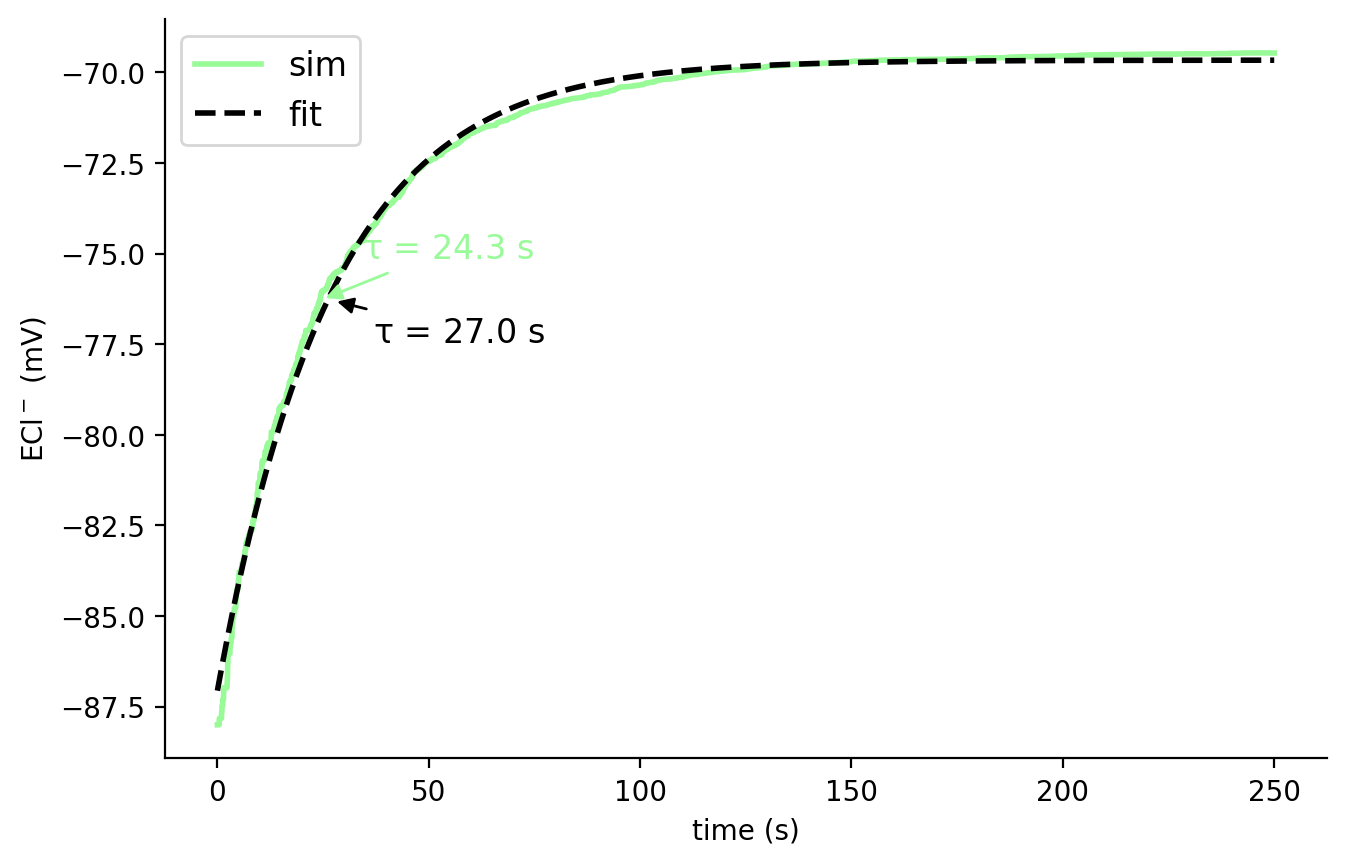

In [9]:
indx = int(total_duration/defaultclock.dt) - 1

# get values from simulation
E_Cl_steady = v_state_mon.E_Cl[0, indx]
E_Cl_steady_0 = E_Cl_steady

# value at 1-1/e of step function (E0 to Esteady)
E_Cl_tau = (E_Cl_steady - E_Cl_0) * (1 - 1 / np.e) + E_Cl_0
tau_index = argmin(np.abs(E_Cl_tau - v_state_mon.E_Cl[0, :indx]))
duration_tau = v_state_mon.t[tau_index]

# exponential fit
from scipy.optimize import curve_fit


def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = v_state_mon.t[:indx] / second
ydata = v_state_mon.E_Cl[0, :indx] / mV

p0 = [E_Cl_steady - E_Cl_0, np.e, E_Cl_0]
np.seterr(all="ignore")
popt, pcov = curve_fit(exp_func, xdata, ydata, p0=p0)

E_Cl_0_fit = (popt[0] + popt[2]) * mV
tau_fit = 1 / popt[1] * second
E_Cl_steady_fit = popt[2] * mV
E_Cl_tau_fit = (E_Cl_steady_fit - E_Cl_0_fit) * (1 - 1 / np.e) + E_Cl_0_fit
print(f"E_Cl_steady_fit  = {E_Cl_steady_fit/mV:.3f} mV")
print(f"tau_fit \t = {tau_fit/second:.3f} s")
print(f"E_Cl_0_fit \t = {E_Cl_0_fit/mV:.3f} mV")

# plot
plot_state(
    xdata*second,
    ydata*mV,
    var_name=text.ECL,
    time_unit=second,
    label="sim",
    color=COLOR.ECL,
)

x_fit = np.linspace(v_state_mon.t[0], v_state_mon.t[indx], 1000) / second
y_fit = exp_func(x_fit, *popt)

plt.plot(x_fit, y_fit, "--", c="k", label="fit")

# plot 1-1/e point

plt.annotate(
    f"$\\tau$ = {duration_tau/second:.1f} s",
    xy=(duration_tau / second, E_Cl_tau / mV),
    xytext=(15, 15),
    ha="left",
    textcoords="offset points", color=COLOR.ECL,
    arrowprops=dict(arrowstyle="-|>", color=COLOR.ECL),
)
plt.annotate(
    f"$\\tau$ = {tau_fit/second:.1f} s",
    xy=(tau_fit / second, E_Cl_tau / mV),
    xytext=(15, -15),
    textcoords="offset points",
    ha="left",
    color="k",
    arrowprops=dict(arrowstyle="-|>", color="k"),
)

plt.legend()

print()
print(f"E_Cl_steady \t = {E_Cl_steady/mV:.3f} mV")
print(f"E_Cl_tau \t = {E_Cl_tau/mV:.3f} mV")
print(f"duration_tau \t = {duration_tau/second:.3f} s")

In [29]:
total_i_cl = np.sum(i_state_mon.I_Cl[0, :indx])

logger.info(
    f"it took {total_duration / second:.3f}s for ECl to go from "
    f"{E_Cl_0 / mV}mV to {E_Cl_steady / mV:.3f}mV through an ICl of {total_i_cl / nA:.3f} nA"
)

tau = calc_tau_kcc2(total_i_cl, E_Cl_steady)

logger.info(f"required compensatory tauKCC2 (for 0 dE_Cl) = {tau / second :.5f} seconds")


INFO       it took 210.000s for ECl to go from -88.0mV to -69.533mV through an ICl of 1060.948 nA [brian2]
INFO       required compensatory tauKCC2 (for 0 dE_Cl) =0.00014 seconds [brian2]


In [30]:
neurons.in_eff = 0
neurons.out_eff = 1
neurons.tau_KCC2 = duration_tau

run(total_duration, report="text")
total_i_cl = np.sum(i_state_mon.I_Cl[0, indx:])
logger.info(f"total_i_cl after= {total_i_cl / nA} nA")
p2_size = i_state_mon.I_Cl[0].size
logger.info(f"ECl after only extrusion = {v_state_mon.E_Cl[0,-1]/mV:.3f} mV")



Starting simulation at t=210. s for a duration of 210. s
69.8454 s (33%) simulated in 10s, estimated 20s remaining.
140.0202 s (66%) simulated in 20s, estimated 10s remaining.
210. s (100%) simulated in 29s


INFO       total_i_cl after= 6694.15522014443 nA [brian2]
INFO       ECl after only extrusion = -87.991 mV [brian2]


In [31]:
logger.info(f"activating both intrusion and extrusion, resetting ECl to {E_Cl_0}")
neurons.in_eff = 1
neurons.out_eff = 1
neurons.E_Cl = E_Cl_0

run(total_duration, report="text")

total_i_cl = np.sum(i_state_mon.I_Cl[0][p2_size:])
E_Cl_steady = v_state_mon.E_Cl[0, -1]
logger.info(
    f"it took {total_duration / second}s for ECl to go from "
    f"{E_Cl_0 / mV}mV to {E_Cl_steady / mV}mV through an ICl of {total_i_cl / nA} nA"
)
logger.info(f"total_i_cl after= {total_i_cl / nA} nA")

run_time = time.time()
run_dt = run_time - setup_time
sum_time = run_time - start_time
logger.info("took {:.2f}s to run (total time = {:.2f}s)".format(run_dt, sum_time))

INFO       activating both intrusion and extrusion, resetting ECl to -88. mV [brian2]


Starting simulation at t=0.42 ks for a duration of 210. s
69.8642 s (33%) simulated in 10s, estimated 20s remaining.
138.6974 s (66%) simulated in 20s, estimated 10s remaining.
208.1017 s (99%) simulated in 30s, estimated < 1s remaining.
210. s (100%) simulated in 30s


INFO       it took 210.0s for ECl to go from -88.0mV to -79.6309761472761mV through an ICl of 3872.312574888147 nA [brian2]
INFO       total_i_cl after= 3872.312574888147 nA [brian2]
INFO       took 94.53s to run (total time = 94.55s) [brian2]


<Axes: xlabel='time (s)', ylabel='$E_{Cl^-}$ (mV)'>

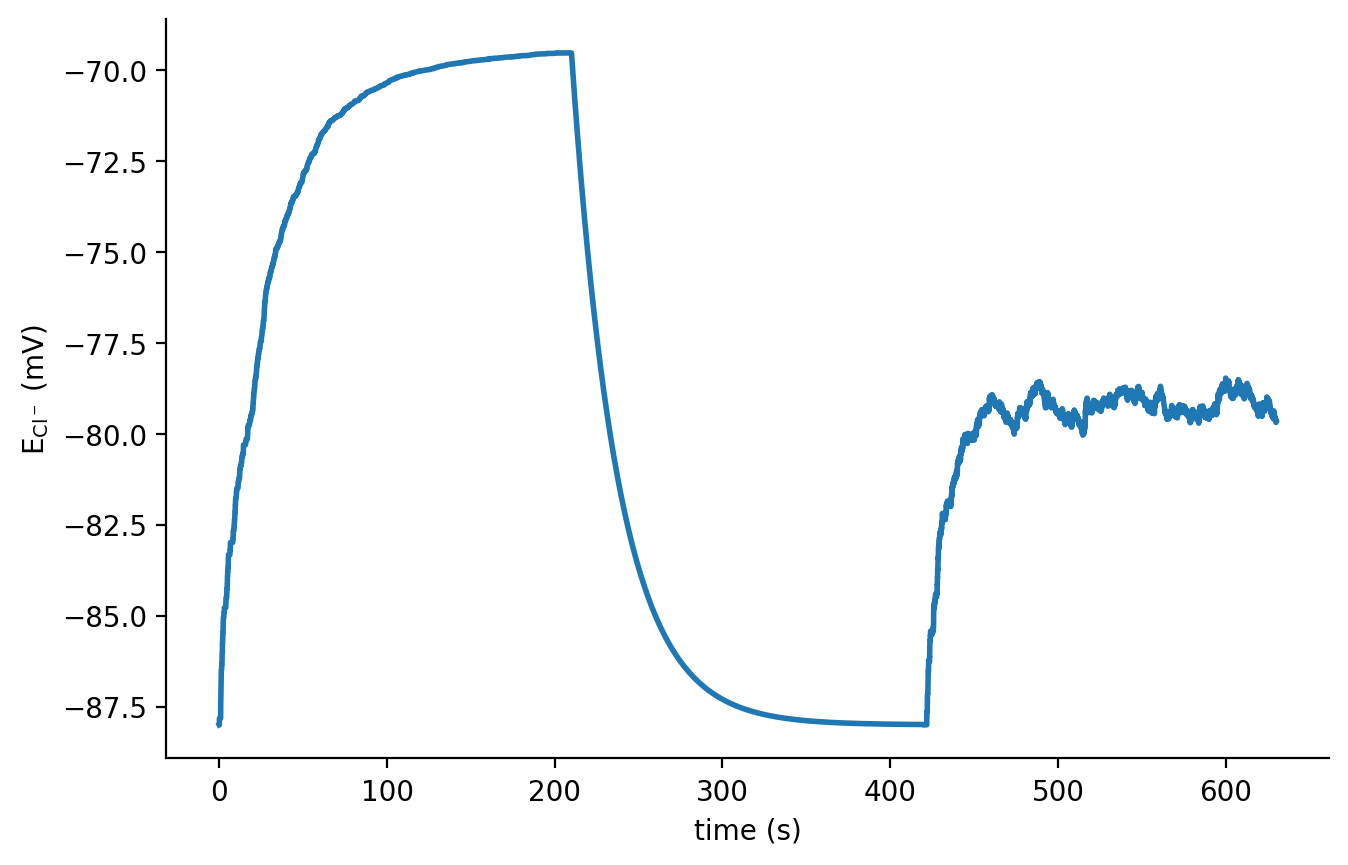

In [32]:
plot_state(v_state_mon.t, v_state_mon.E_Cl.T, time_unit=time_unit, var_name='$E_{Cl^-}$')

INFO       total_i = 11627.415729018068 nA [brian2]
WARNING    /home/ccurrin/mambaforge/envs/brian2/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]
2023-06-09 15:50:24 [ WARNING] /home/ccurrin/mambaforge/envs/brian2/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 (py.warnings::warnings.py::109)


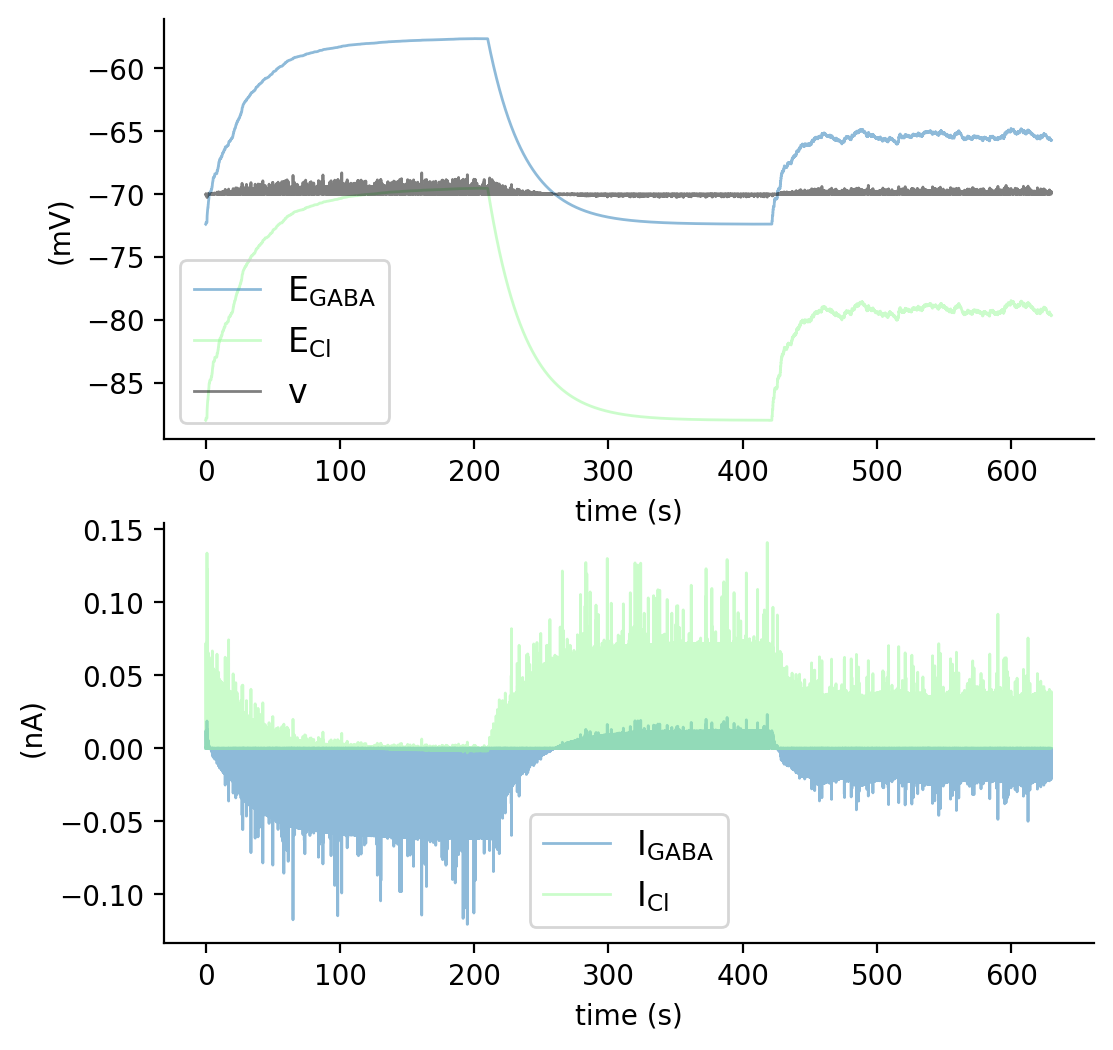

In [33]:
fix, ax = plt.subplots(2, 1, figsize=(6, 6))
colors = [COLOR.inh, COLOR.ECL, "k"]
for v_var, c in zip(v_vars, colors):
    plot_state(
        v_state_mon.t,
        getattr(v_state_mon, v_var).T,
        axes=ax[0],
        var_name="",
        var_unit=mV,
        time_unit=time_unit,
        lw=1,
        alpha=0.5,
        c=c,
    )
ax_to_annotate: Axes = ax[1]
ax_to_annotate.annotate(
    f"$\tau={tau / second} s$", xy=(initial_size, E_Cl_steady_0 / mV)
)

for i_var, c in zip(i_vars, colors):
    plot_state(
        i_state_mon.t,
        getattr(i_state_mon, i_var).T,
        axes=ax[1],
        var_name="",
        var_unit=nA,
        time_unit=time_unit,
        lw=1,
        alpha=0.5,
        c=c,
    )

ax[0].set_ylabel("(mV)")
v_vars_leg = []
for v_var in v_vars:
    tmp = v_var.replace("_", "_{")
    tmp = tmp + "}" if "{" in tmp else tmp
    v_vars_leg.append(f"${tmp}$")
i_vars_leg = []
for i_var in i_vars:
    tmp = i_var.replace("_", "_{")
    tmp = tmp + "}" if "{" in tmp else tmp
    i_vars_leg.append(f"${tmp}$")
ax[0].legend(v_vars_leg)
ax[1].legend(i_vars_leg)

total_i = np.sum(i_state_mon.I_Cl) / nA

logger.info(f"total_i = {total_i} nA")

if matplotlib.get_backend().lower() not in ["agg", "pdf"]:
    show()